Deep Learning
=============

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import math
import tarfile, itertools
import pandas as pd
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from keras import activations
from keras.models import Sequential
from keras.layers import Dense, Reshape, Conv2D, MaxPooling2D, Dropout, Flatten
from sklearn.metrics import confusion_matrix
from vis.utils import utils
from vis.utils.utils import find_layer_idx
from vis.visualization import visualize_saliency
from keras.optimizers import Adam, SGD
import tensorflow as tf
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from keras.backend.tensorflow_backend import set_session

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

Using TensorFlow backend.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

In [13]:
pkl_files = 'full_data.pickle'
with open(pkl_files, 'rb') as file:
    data = pickle.load(file)
    X_tr = data['train_dataset']
    y_tr = data['train_labels']
    X_val = data['valid_dataset']
    y_val = data['valid_labels']
    X_test = data['test_dataset']
    y_test = data['test_labels']
    print(data['train_dataset'].shape)
    print(data['train_labels'].shape)
    print(data['valid_dataset'].shape)
    print(data['valid_labels'].shape)
    print(data['test_dataset'].shape)
    print(data['test_labels'].shape)

(45000, 28, 28)
(45000,)
(7000, 28, 28)
(7000,)
(1870, 28, 28)
(1870,)


---
Display
---------

Displaying some sample of the labels and images in training set.

---

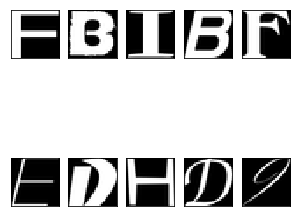

In [18]:
letter_samples = []
indices = np.random.choice(X_test.shape[0], 10, replace=False)
for idx in indices:
    letter_samples.append(X_test[idx, :, :, 0])

fig, ax = plt.subplots(2, 5, figsize=(5, 5))
for i, j in itertools.product(range(2), range(5)):
    ax[i, j].get_xaxis().set_visible(False)
    ax[i, j].get_yaxis().set_visible(False)
    ax[i, j].cla()
    ax[i, j].imshow(letter_samples[i*5 + j], cmap='gray')

plt.show()        

---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [ ]:
def count_overlap(set1, set2):
    count = 0
    for img1 in set1:
        for img2 in set2:
            if np.array_equal(img1, img2):
                count += 1
    return count

train_valid = count_overlap(data['train_dataset'], data['valid_dataset'])
train_test = count_overlap(data['train_dataset'], data['test_dataset'])
valid_test = count_overlap(data['valid_dataset'], data['test_dataset'])

In [ ]:
print('Overlap between train and valid:', train_valid) # 37135
print('Overlap between train and test:', train_test) # 9991
print('Overlap between valid and test:', valid_test) # 1644

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

### Logistic regression model

In [5]:
# Logistic regression model
nsamples, nx, ny = X_tr.shape
train_dataset = X_tr.reshape((nsamples, nx*ny))

lr_model = LogisticRegression()
lr_model.fit(train_dataset, y_tr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [6]:
nsamples, nx, ny = X_test.shape
test_dataset = X_test.reshape((nsamples, nx*ny))

acc = lr_model.score(test_dataset, y_test)
print('Accuracy: ', acc)

Accuracy:  0.8748663101604278


### TensorFlow Convolution model

In [7]:
def next_batch(step, batch_size, data, labels):
    return data[step*batch_size:(step + 1)*batch_size], labels[step*batch_size:(step + 1)*batch_size]

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [8]:
# Input
x_input = tf.placeholder(tf.float32, shape=[None, 28, 28])
y_label = tf.placeholder(tf.float32, shape=[None, 10])
x_image = tf.reshape(x_input, [-1, 28, 28, 1])

# Convoution layer 1
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# Convoution layer 2
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# FC layer
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Dropout
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Softmax layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Epoch: 0 - Accuracy: 0.829
Epoch: 1 - Accuracy: 0.856
Epoch: 2 - Accuracy: 0.866
Epoch: 3 - Accuracy: 0.874571
Epoch: 4 - Accuracy: 0.881429
Epoch: 5 - Accuracy: 0.886571
Epoch: 6 - Accuracy: 0.892143
Epoch: 7 - Accuracy: 0.895
Epoch: 8 - Accuracy: 0.898286
Epoch: 9 - Accuracy: 0.901286
Epoch: 10 - Accuracy: 0.902286
Epoch: 11 - Accuracy: 0.902571
Epoch: 12 - Accuracy: 0.901714
Epoch: 13 - Accuracy: 0.906143
Epoch: 14 - Accuracy: 0.907286
Epoch: 15 - Accuracy: 0.906571
Epoch: 16 - Accuracy: 0.907857
Epoch: 17 - Accuracy: 0.907
Epoch: 18 - Accuracy: 0.909571
Epoch: 19 - Accuracy: 0.909429
Epoch: 20 - Accuracy: 0.908857
Epoch: 21 - Accuracy: 0.909571
Epoch: 22 - Accuracy: 0.910429
Epoch: 23 - Accuracy: 0.907571
Epoch: 24 - Accuracy: 0.909857
Epoch: 25 - Accuracy: 0.909143
Epoch: 26 - Accuracy: 0.911
Ep

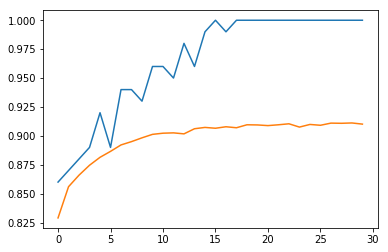

In [9]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_label, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_label, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

epochs = 30
batch_size = 100
steps = math.ceil(X_tr.shape[0] // batch_size)

y_tr = pd.get_dummies(y_tr).values
y_val = pd.get_dummies(y_val).values
y_test = pd.get_dummies(y_test).values
train_accs = []
eval_accs = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        for step in range(steps):
            batch_X, batch_y = next_batch(step, batch_size, X_tr, y_tr)
            train_step.run(feed_dict={x_input: batch_X, y_label: batch_y, keep_prob: 0.5})
        train_accuracy = accuracy.eval(feed_dict={x_input: batch_X, y_label: batch_y, keep_prob: 1.0})
        eval_accuracy = accuracy.eval(feed_dict={x_input: X_val, y_label: y_val, keep_prob: 1.0})
        train_accs.append(train_accuracy)
        eval_accs.append(eval_accuracy)
        print('Epoch: %d - Accuracy: %g' % (epoch, eval_accuracy))
    accuracy_l = accuracy.eval(feed_dict={x_input: X_test, y_label: y_test, keep_prob: 1.0})
    print('test accuracy ', accuracy_l)
        
x = np.array(range(epochs))
plt.plot(x, train_accs)
plt.plot(x, eval_accs)
plt.show()

## Keras model

In [4]:
model = Sequential()
# model.add(Reshape((28, 28, 1), input_shape=(784,)))
model.add(Conv2D(32, (5, 5), padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (5, 5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [5]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['accuracy'])

In [15]:
epochs = 20
batch_size = 100
X_tr = np.expand_dims(X_tr, axis=len(X_tr.shape))
X_val = np.expand_dims(X_val, axis=len(X_val.shape))
X_test = np.expand_dims(X_test, axis=len(X_test.shape))
y_tr = pd.get_dummies(y_tr).values
y_val = pd.get_dummies(y_val).values
y_test = pd.get_dummies(y_test).values

In [6]:
model.fit(X_tr, y_tr,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, y_val)
         )

Train on 45000 samples, validate on 7000 samples
Epoch 1/20
45000/45000 [==============================] - 7s 150us/step - loss: 0.7958 - acc: 0.7791 - val_loss: 0.5096 - val_acc: 0.8474
Epoch 2/20
45000/45000 [==============================] - 6s 130us/step - loss: 0.4916 - acc: 0.8567 - val_loss: 0.4293 - val_acc: 0.8726
Epoch 3/20
45000/45000 [==============================] - 6s 123us/step - loss: 0.4270 - acc: 0.8745 - val_loss: 0.3779 - val_acc: 0.8870
Epoch 4/20
45000/45000 [==============================] - 6s 125us/step - loss: 0.3859 - acc: 0.8865 - val_loss: 0.3532 - val_acc: 0.8936
Epoch 5/20
45000/45000 [==============================] - 5s 119us/step - loss: 0.3573 - acc: 0.8945 - val_loss: 0.3368 - val_acc: 0.8957
Epoch 6/20
45000/45000 [==============================] - 5s 121us/step - loss: 0.3352 - acc: 0.8998 - val_loss: 0.3281 - val_acc: 0.8997
Epoch 7/20
45000/45000 [==============================] - 5s 122us/step - loss: 0.3165 - acc: 0.9051 - val_loss: 0.3213 - v

In [7]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.14600102091855544
Test accuracy: 0.9545454543542097


In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              3212288   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
__________

In [23]:
def predict_(model, X_val, y_val):
    preds = model.predict(X_val).flatten()
#     print('predict: ')
#     mat = confusion_matrix(y_val, preds >= 0.5)
#     print('confusion_matrix')
#     print(mat)
    
    # Draw Attention Map
    layer_idx = find_layer_idx(model, 'dense_2')
    model.layers[layer_idx].activation = activations.linear
    model = utils.apply_modifications(model)

    for n in range(10):
        print(n)
        print('Ground Truth: ')
        print(y_val[n])
#         if preds[n] >= 0.5:
        if True:
            fig = plt.figure(figsize=(16,16))
            grads = visualize_saliency(model, layer_idx, filter_indices=None, seed_input=X_val[n])

            ax1 = plt.subplot(1, 2, 1)
            ax1.title.set_text('predict: ' + str(preds[n]))
            ax1.imshow(X_val[n, :, :, 0], cmap='gray')
            ax1.imshow(grads, cmap='jet', alpha=0.7)
            
            ax2 = plt.subplot(1, 2, 2)
            ax2.title.set_text('Ground Truth' + str(y_val[n]))
            ax2.imshow(X_val[n, :, :, 0], cmap='gray')
            plt.show()
#     print('confusion_matrix')
#     print(mat)

0
Ground Truth: 
[0 0 0 0 0 0 0 0 0 1]


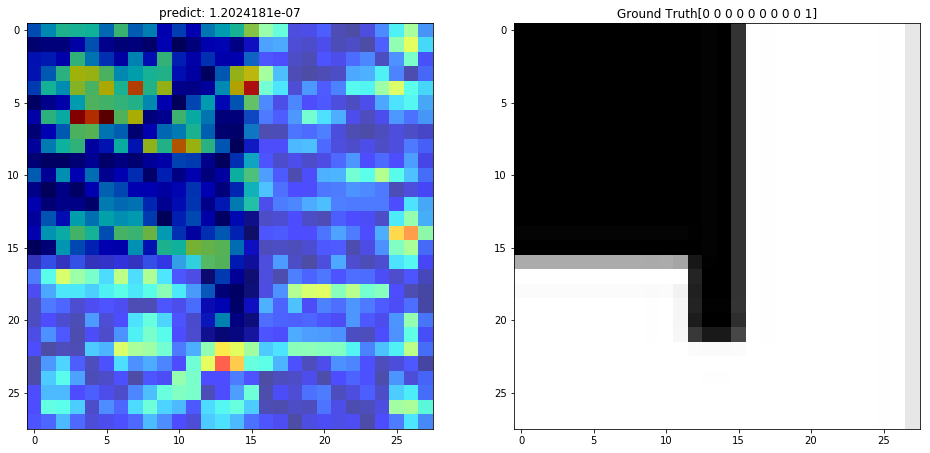

1
Ground Truth: 
[0 0 0 0 0 1 0 0 0 0]


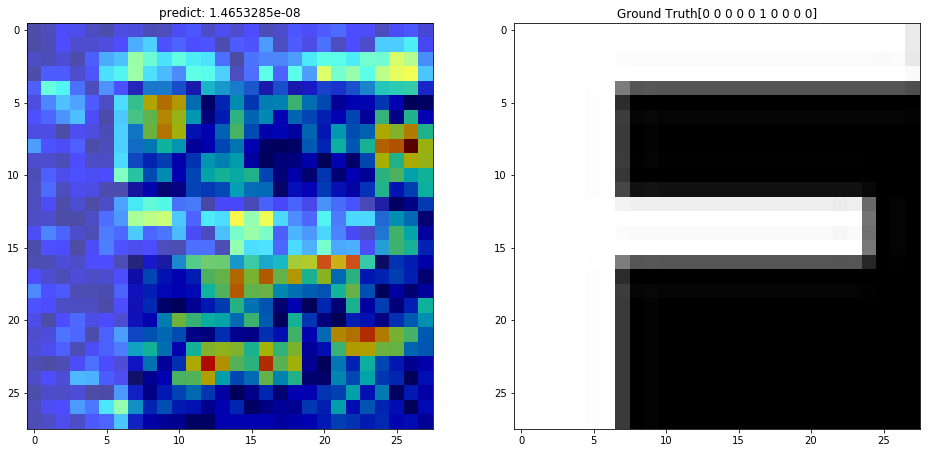

2
Ground Truth: 
[0 0 0 0 0 0 0 0 0 1]


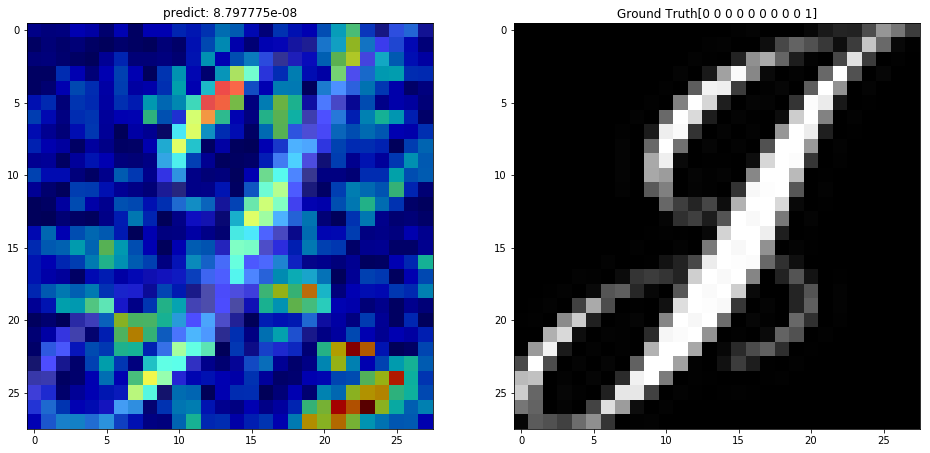

3
Ground Truth: 
[0 0 0 0 0 0 0 0 1 0]


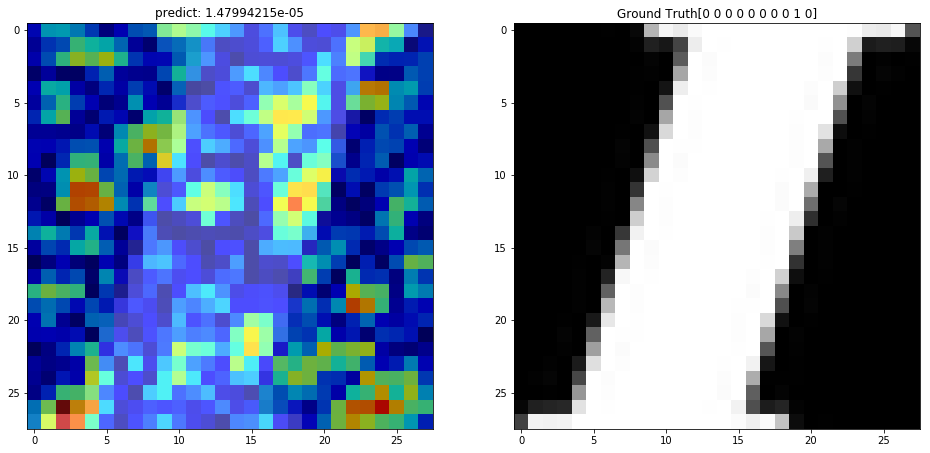

4
Ground Truth: 
[0 1 0 0 0 0 0 0 0 0]


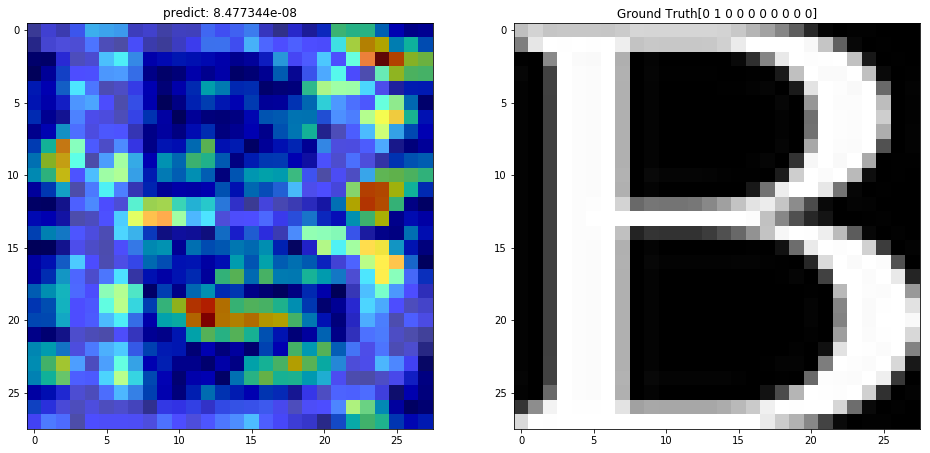

5
Ground Truth: 
[0 0 0 0 0 0 0 1 0 0]


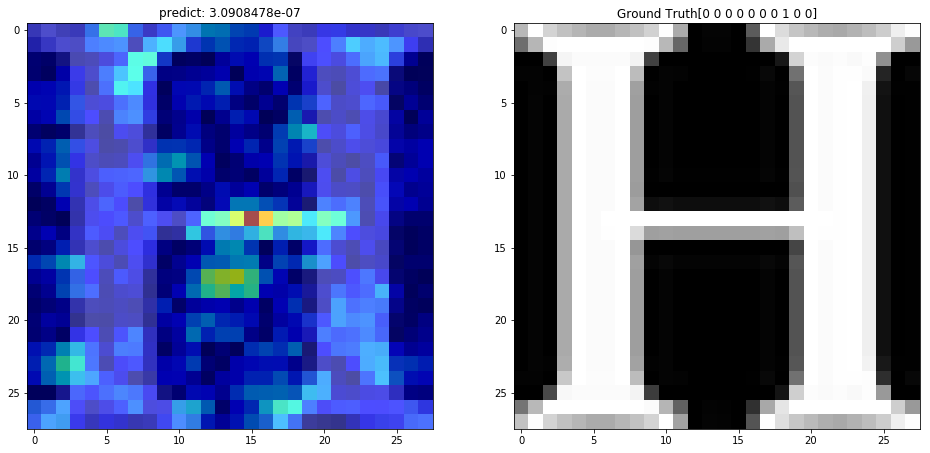

6
Ground Truth: 
[0 0 1 0 0 0 0 0 0 0]


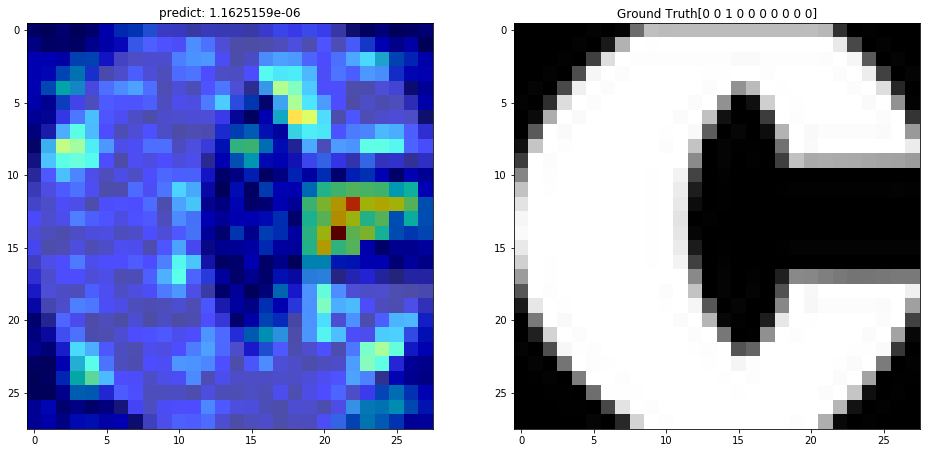

7
Ground Truth: 
[0 0 0 0 0 0 1 0 0 0]


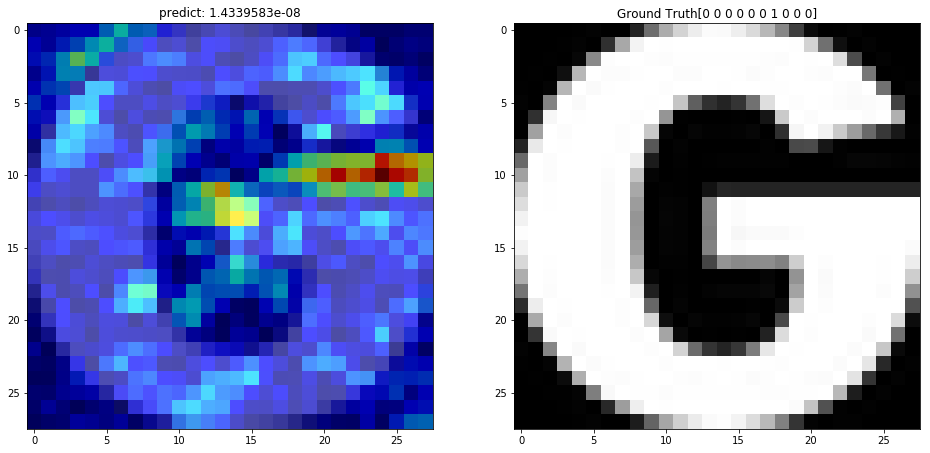

8
Ground Truth: 
[1 0 0 0 0 0 0 0 0 0]


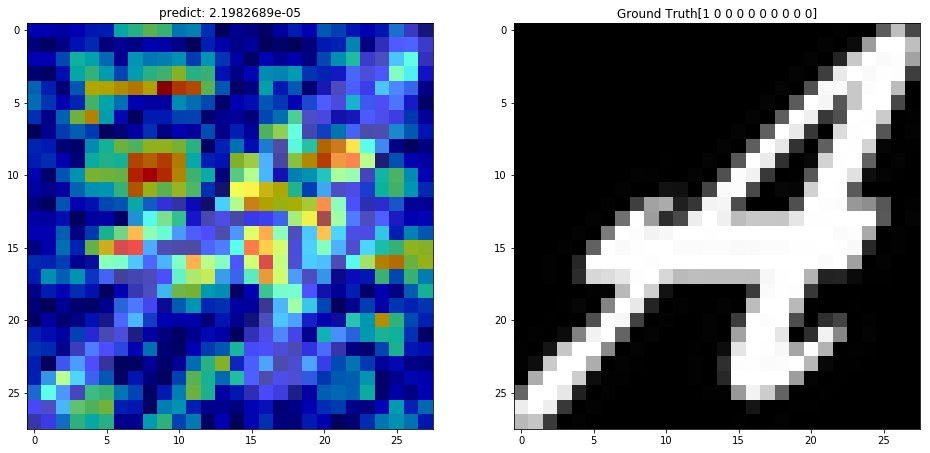

9
Ground Truth: 
[0 0 0 1 0 0 0 0 0 0]


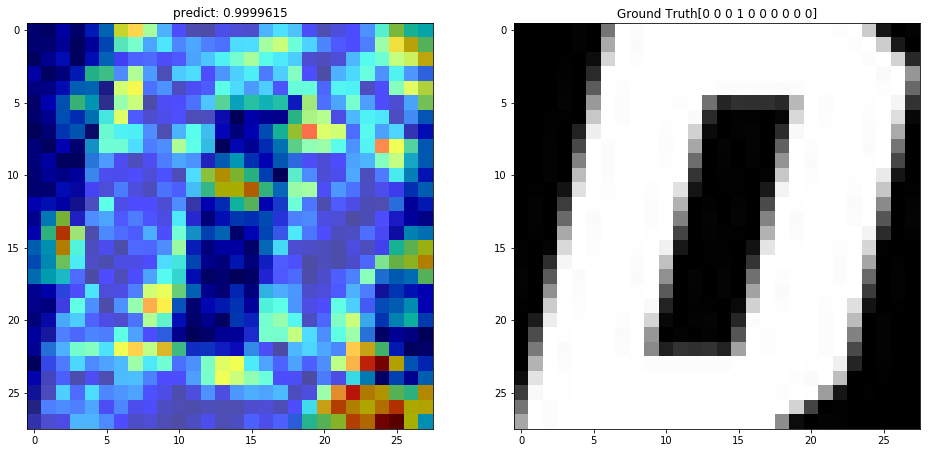

In [24]:
predict_(model, X_test, y_test)